In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# First let import the most necessary libs
import pandas as pd
import numpy as np
# Library to import pre-trained model for sentence embeddings
from sentence_transformers import SentenceTransformer
# Calculate similarities between sentences
from sklearn.metrics.pairwise import cosine_similarity
# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt
# package for finding local minimas
from scipy.signal import argrelextrema

In [ ]:
text = 'Let me tell you a little story. When I was a little kid I really liked to play football. "I wanted to be" like Messi and play at Camp Nou. However, I was really bad at it and now I’m not training at Camp Nou. I’m writing a medium article on embeddings. In this article, I want to show how are we going to split a text into parts. We first embed sentences. Then we compute sentence similarities. After that, we detect the split point in the text. After finishing this process we will go play chess with friends.'

In [ ]:
# Loading a model - don't try it at home, it might take some time - it is 420 mb
model = SentenceTransformer('all-mpnet-base-v2')
# Split text into sentences
sentences = text.split('. ')
# Embed sentences
embeddings = model.encode(sentences)
print(embeddings.shape)

(10, 768)


In [ ]:
#select  row (sentence) and all columns
first_sentence = embeddings[0,:]
second_sentence = embeddings[1,:]
third_sentence = embeddings[2,:]
fourth_sentence = embeddings[3,:]
fifth_sentence = embeddings[4,:]

# How similar is second and third sentence
print(f'Dot product of second and third sentence is {second_sentence @ third_sentence}')
print(f'Dot product of third and fourth sentence is {third_sentence @ fourth_sentence}')
print(f'Dot product of fourth and fith sentence is {fourth_sentence @ fifth_sentence}')

Dot product of second and third sentence is 0.3170683979988098
Dot product of third and fourth sentence is 0.3447301387786865
Dot product of fourth and fith sentence is -0.04014214128255844


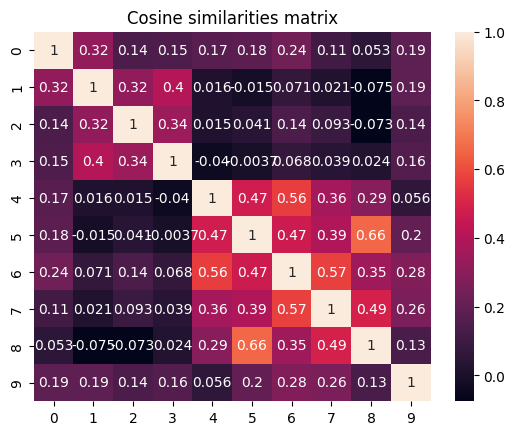

In [ ]:
# Create similarities matrix
similarities = cosine_similarity(embeddings)
# Let's plot the result we got
sns.heatmap(similarities,annot=True).set_title('Cosine similarities matrix');

In [ ]:
import math

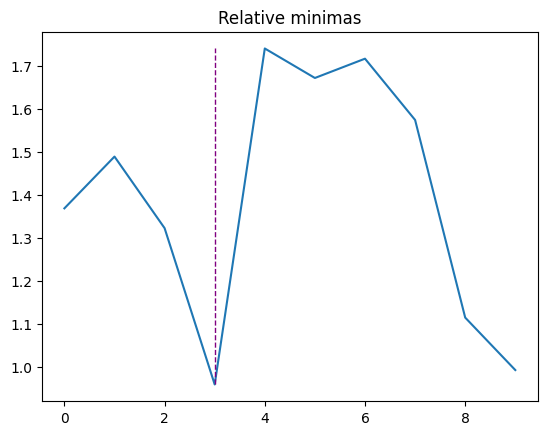

In [ ]:
def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))

def activate_similarities(similarities:np.array, p_size=10)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum
        Returns:
            list: list of weighted sums
        """
        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid)
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

# Lets apply our function. For long sentences i reccomend to use 10 or more sentences
activated_similarities = activate_similarities(similarities, p_size=5)

# lets create empty fig for our plor
fig, ax = plt.subplots()
### 6. Find relative minima of our vector. For all local minimas and save them to variable with argrelextrema function
minmimas = argrelextrema(activated_similarities, np.less, order=2) #order parameter controls how frequent should be splits. I would not reccomend changing this parameter.
# plot the flow of our text with activated similarities
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative minimas');
# Now lets plot vertical lines in order to see where we created the split
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

In [ ]:

#Get the order number of the sentences which are in splitting points
split_points = [each for each in minmimas[0]]
# Create empty string
text = ''
for num,each in enumerate(sentences):
    # Check if sentence is a minima (splitting point)
    if num in split_points:
        # If it is than add a dot to the end of the sentence and a paragraph before it.
        text+=f'\n\n {each}. '
    else:
        # If it is a normal sentence just add a dot to the end and keep adding sentences.
        text+=f'{each}. '

In [ ]:
text

'Let me tell you a little story. When I was a little kid I really liked to play football. "I wanted to be" like Messi and play at Camp Nou. \n\n However, I was really bad at it and now I’m not training at Camp Nou. I’m writing a medium article on embeddings. In this article, I want to show how are we going to split a text into parts. We first embed sentences. Then we compute sentence similarities. After that, we detect the split point in the text. After finishing this process we will go play chess with friends.. '